In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

2025-05-21 17:46:54.277729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 17:46:54.294216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747874814.311024   73537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747874814.316561   73537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747874814.330823   73537 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
#Set random seed
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
image_size = (224, 224) 
batch_size = 32 
train_dir = 'src/../input/brain-tumor-classification-mri/Training' 
test_dir = 'src/../input/brain-tumor-classification-mri/Testing' 


# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomRotation(0.1), 
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomZoom(0.1)
# ])


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred', # detect classes from input folder
    label_mode='categorical', # One-hot encoding
    image_size=image_size, # Resize images
    interpolation='bicubic', # Resize method
    batch_size=batch_size,
    shuffle=True, # Shuffle the data
    seed=42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='bicubic',
    batch_size=batch_size,
    shuffle=True,
    seed=42 
)

# Optimize loading the dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)



Found 2870 files belonging to 4 classes.


I0000 00:00:1747874817.779193   73537 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 394 files belonging to 4 classes.


In [4]:
X_list = []
y_list = []

for image_batch, label_batch in train_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy())

for image_batch, label_batch in test_dataset:
    X_list.append(image_batch.numpy())
    y_list.append(label_batch.numpy()) 

#Conver batches into np arrays
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

2025-05-21 17:47:00.050844: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-21 17:47:00.182494: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (2872, 224, 224, 3)
y_train shape: (2872, 4)
X_test shape: (392, 224, 224, 3)
y_test shape: (392, 4)


In [5]:
model = tf.keras.models.load_model('CNN_model.keras') 

In [6]:
X_train_CNN = preprocess_input(X_train.astype(np.float32))
X_test_CNN = preprocess_input(X_test.astype(np.float32))
#Perfrom prediction
y_pred = model.predict(X_test_CNN)

#Convert the highest probability to corresponding class label (index)
y_test_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(y_pred, axis=1)

class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Report accuracy and 
loss, accuracy = model.evaluate(X_test_CNN, y_test, verbose = 2)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

I0000 00:00:1747874828.274224   73682 service.cc:152] XLA service 0x7f66ec0026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747874828.274264   73682 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-21 17:47:08.357267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747874829.037556   73682 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-21 17:47:09.810759: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 560 bytes spill stores, 560 bytes spill loads

2025-05-21 17:47:09.862239: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_327

 2/13 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

I0000 00:00:1747874833.961444   73682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

2025-05-21 17:47:17.676521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 8 bytes spill stores, 8 bytes spill loads

2025-05-21 17:47:17.915345: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 440 bytes spill stores, 440 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       109
  meningioma       0.93      0.97      0.95       105
    no_tumor       0.97      0.98      0.98        60
   pituitary       0.99      0.99      0.99       118

    accuracy                           0.97       392
   macro avg       0.97      0.97      0.97       392
weighted avg       0.97      0.97      0.97       392

13/13 - 8s - 586ms/step - accuracy: 0.9668 - loss: 0.1323
Accuracy:  0.9668367505073547
Loss:  0.13231702148914337


In [7]:
def plot_confustion_matrix(actual, predicted):
    #Show confustion matrix
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

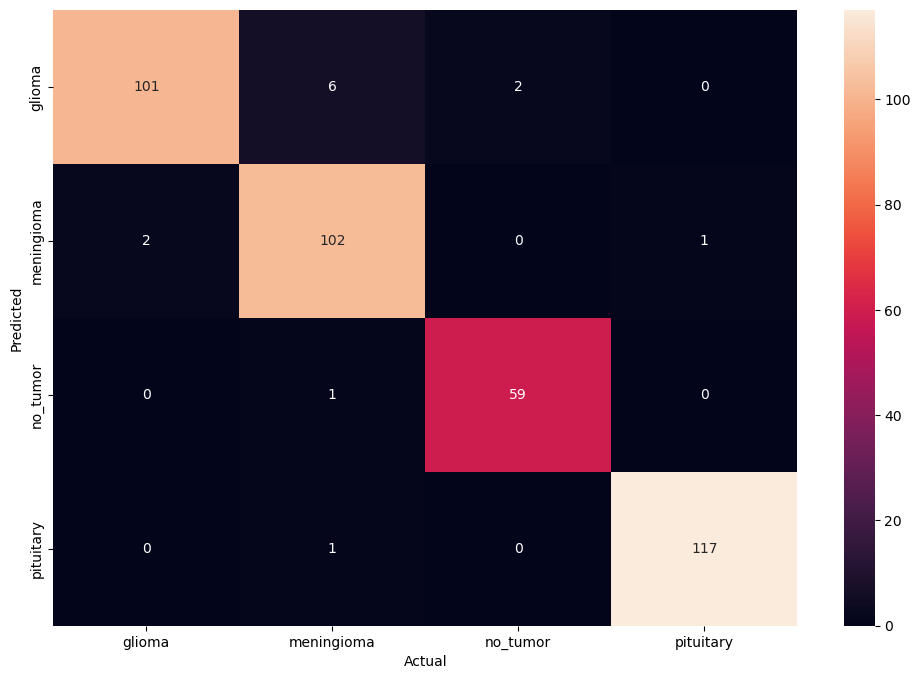

In [8]:
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label)

In [9]:
#Reload the CNN model
trained_CNN_model = tf.keras.models.load_model('CNN_model.keras')

#Uncomment the following line to see the model's architecture
# trained_CNN_model.summary()

#Retrieve the output of the GlobalAvgPool2D layer, which serves as the input for the final Dense layer
features_extractor = tf.keras.models.Model(inputs=trained_CNN_model.input, outputs=trained_CNN_model.get_layer('global_average_pooling2d').output)

#Extract features from input images. These features will be used to train and test on other models
X_train = features_extractor.predict(X_train_CNN)
X_test = features_extractor.predict(X_test_CNN)

#One-hot encoded to index label
y_train_label = np.argmax(y_train, axis=1)
y_test_label = np.argmax(y_test, axis=1)

#Standardize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train_label.shape)
print(y_test_label.shape)

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
(2872, 2048)
(392, 2048)
(2872,)
(392,)


In [10]:
#SVM (Support Vector Machine) classifier
SVM_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
SVM_model.fit(X_train_scaled, y_train_label)

SVC(probability=True)

              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       109
  meningioma       0.91      0.97      0.94       105
    no_tumor       0.98      0.98      0.98        60
   pituitary       0.98      0.97      0.98       118

    accuracy                           0.96       392
   macro avg       0.97      0.97      0.97       392
weighted avg       0.97      0.96      0.96       392

Accuracy:  0.9642857142857143


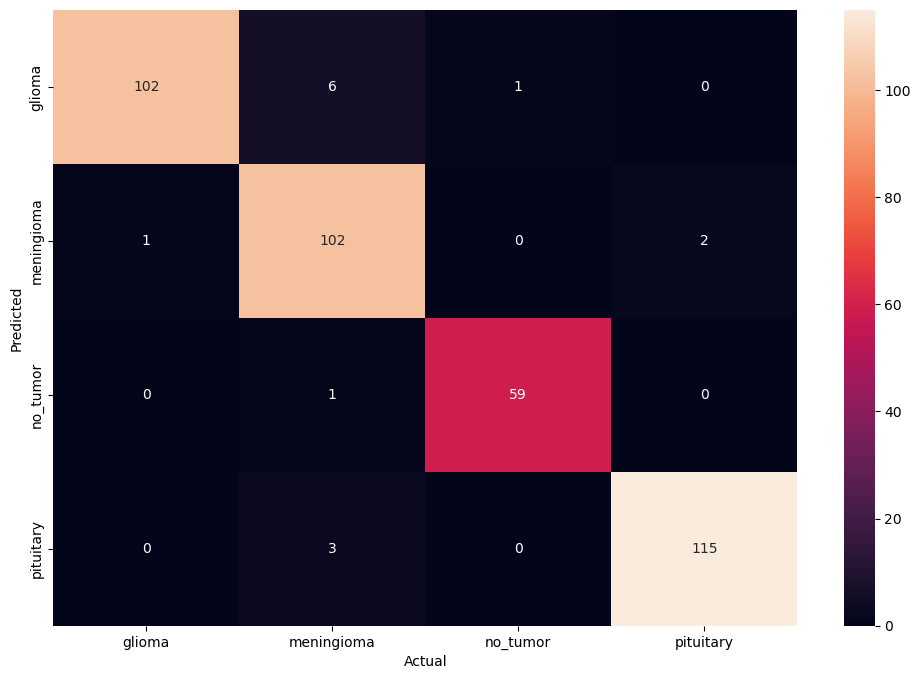

In [11]:
#Perform prediction with SVM model
y_pred_label = SVM_model.predict(X_test_scaled)

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Calculate the accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print("Accuracy: ", accuracy)

#Plot the confusion matrix
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label)

In [12]:
#Random Forest Classifier
RF_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

RF_model.fit(X_train_scaled, y_train_label)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       109
  meningioma       0.86      0.96      0.91       105
    no_tumor       1.00      0.92      0.96        60
   pituitary       0.97      0.98      0.97       118

    accuracy                           0.94       392
   macro avg       0.95      0.94      0.94       392
weighted avg       0.95      0.94      0.94       392

Accuracy:  0.9413265306122449


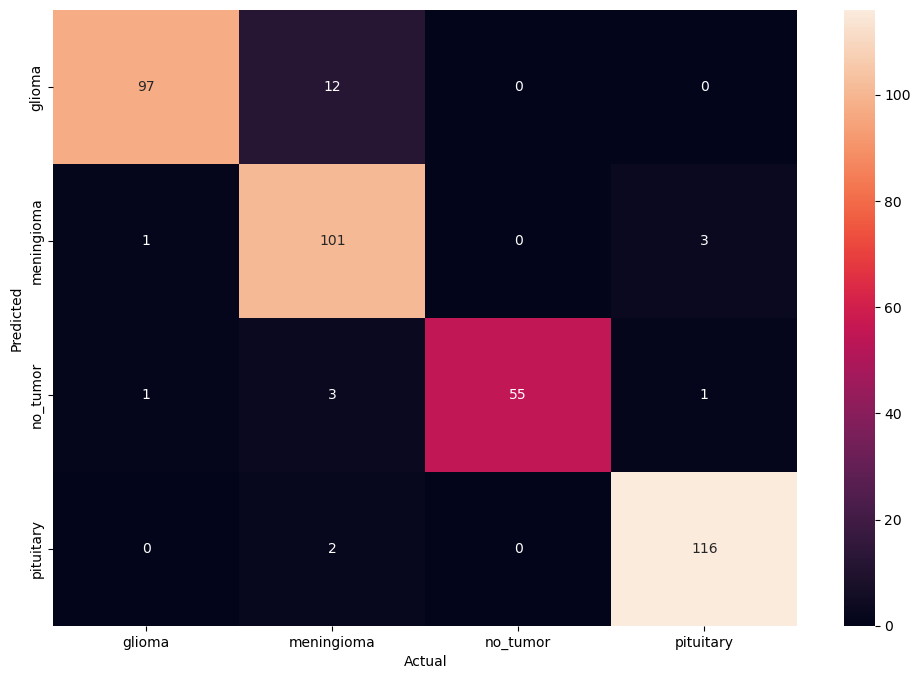

In [13]:
#Perform prediction with Random Forest model
y_pred_label = RF_model.predict(X_test_scaled)

#Compare to true labels
print(classification_report(y_test_label, y_pred_label, target_names=class_labels))

#Calculate the accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print("Accuracy: ", accuracy)

#Plot the confusion matrix
plot_confustion_matrix(actual=y_test_label, predicted=y_pred_label)